#### 00. IMPORT DE PACOTES E FUNÇÕES ÚTEIS

- Módulos criados para o projeto também são carregados

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import model_selection
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from feature_engine.encoding import OneHotEncoder
from feature_engine import discretisation

from lightgbm import LGBMClassifier

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

from pipeline.preprocess import *
from pipeline.utils import *
from pipeline.carregar_dados import *
from pipeline.criar_abt import *

from features.features_clientes import *
from features.features_quantidade import *
from features.features_valor import *
from features.features_tempo import *
from features.features_flags import *
from features.features_clientes_transacional import *

#### 01. CARREGAR DADOS ORIGINAIS COM PRÉ-PROCESSAMENTO MÍNIMO

In [2]:
dados = carregar_dados()

df_clientes = dados['clientes']
df_inadimplencia = dados['inadimplencia']
df_transacoes = dados['transacoes']

clientes_prep = preprocessar_clientes(df_clientes)
inad_prep = preprocessar_inadimplencia(df_inadimplencia)
tran_prep = preprocessar_transacoes(df_transacoes)

inad_prep = inad_prep.dropna(subset=["atraso_90d"]).copy()

print("Clientes:", clientes_prep.shape)
print("Inadimplência:", inad_prep.shape)
print("Transações:", tran_prep.shape)

Clientes: (200, 10)
Inadimplência: (4790, 4)
Transações: (2000, 4)


#### 02. GERAÇÃO DA ABT 

- Merge com as bases de features criadas.

- Cada unidade experimental corresponderá ao par *id_cliente* + *data_referencia*, e as variáveis corresponderão a essa referência.

- A base que será utilizada durante todo o desenvolvimento teve os cálculos de suas features baseados numa janela de observação M-1, garantindo assim que não utilize dados do mesmo mês a que a coluna *mes_safra* da base de inadimplência se refere.

- Como será observado adiante, a taxa de inadimplência tem valor de 10%, o que pode gerar alguns problemas durante a modelagem devido ao desbalanceamento.

In [3]:
abt = gerar_abt(clientes_prep, 
                inad_prep, 
                tran_prep, 
                usar_M_1=True)

print("Shape M-1:", abt.shape)

Shape M-1: (4790, 99)


In [4]:
abt_M = gerar_abt(clientes_prep,
                  inad_prep,
                  tran_prep,
                  usar_M_1=False)

print("Shape M:", abt_M.shape)

Shape M: (4790, 99)


In [10]:
abt.head(10)

,id_cliente,mes_safra,data_referencia,atraso_90d,idade,renda_mensal,data_abertura_conta,mes_abertura_conta,estado_civil,tempo_emprego_anos,qtde_produtos,score_interno,limite_credito,idade2,log_renda,renda_por_limite,multi_produto_flag,vlr_trans_1m,vlr_trans_3m,vlr_trans_6m,vlr_trans_9m,vlr_trans_12m,vlr_trans_24m,vlr_trans_ever,vlr_trans_ult,vlr_trans_max,vlr_trans_min,comp_vlr_1m_vs_3m,delta_vlr_1m_vs_3m,comp_vlr_3m_vs_6m,delta_vlr_3m_vs_6m,comp_vlr_6m_vs_9m,delta_vlr_6m_vs_9m,comp_vlr_9m_vs_12m,delta_vlr_9m_vs_12m,comp_vlr_12m_vs_24m,delta_vlr_12m_vs_24m,comp_vlr_24m_vs_ever,delta_vlr_24m_vs_ever,qtde_trans_1m,qtde_trans_3m,qtde_trans_6m,qtde_trans_9m,qtde_trans_12m,qtde_trans_24m,qtde_trans_ever,pct_qtde_trans_1m,pct_qtde_trans_3m,pct_qtde_trans_6m,pct_qtde_trans_12m,pct_qtde_trans_24m,comp_qtde_1m_vs_3m,delta_qtde_1m_vs_3m,comp_qtde_3m_vs_6m,delta_qtde_3m_vs_6m,comp_qtde_6m_vs_9m,delta_qtde_6m_vs_9m,comp_qtde_9m_vs_12m,delta_qtde_9m_vs_12m,comp_qtde_12m_vs_24m,delta_qtde_12m_vs_24m,comp_qtde_24m_vs_ever,delta_qtde_24m_vs_ever,tempo_desde_primeira_1m,tempo_desde_ultima_1m,tempo_desde_primeira_3m,tempo_desde_ultima_3m,tempo_desde_primeira_6m,tempo_desde_ultima_6m,tempo_desde_primeira_9m,tempo_desde_ultima_9m,tempo_desde_primeira_12m,tempo_desde_ultima_12m,tempo_desde_primeira_24m,tempo_desde_ultima_24m,tempo_desde_primeira_ever,tempo_desde_ultima_ever,flag_nunca_transacionou,flag_transacao_1m,flag_transacao_3m,flag_transacao_6m,flag_transacao_9m,flag_transacao_12m,flag_transacao_24m,flag_transacao_ever,tempo_relacionamento_anos,tempo_relacionamento_meses,tempo_relacionamento_isna,flag_cliente_antigo,flag_cliente_antigo_isna,idade_relativa,limite_por_ano_conta,limite_por_ano_conta_isna,limite_por_mes_conta,limite_por_mes_conta_isna,produtos_por_ano_conta,produtos_por_ano_conta_isna,produtos_por_mes_conta,produtos_por_mes_conta_isna
0,C0001,2023-09,2023-09-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7139,20.5650,0,0.0,0,54.2861,13439.523893,0,1120.058352,0,2.917323,0,0.243132,0
1,C0001,2023-10,2023-10-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7960,21.5506,0,0.0,0,54.2040,12825.167038,0,1068.833350,0,2.783964,0,0.232012,0
2,C0001,2023-11,2023-11-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8809,22.5690,0,0.0,0,54.1191,12246.265086,0,1020.603483,0,2.658302,0,0.221543,0
3,C0001,2023-12,2023-12-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9630,23.5545,0,0.0,0,54.0370,11734.080489,0,977.902312,0,2.547122,0,0.212274,0
4,C0001,2024-01,2024-01-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,

In [11]:
abt_M.head(10)

,id_cliente,mes_safra,data_referencia,atraso_90d,idade,renda_mensal,data_abertura_conta,mes_abertura_conta,estado_civil,tempo_emprego_anos,qtde_produtos,score_interno,limite_credito,idade2,log_renda,renda_por_limite,multi_produto_flag,vlr_trans_1m,vlr_trans_3m,vlr_trans_6m,vlr_trans_9m,vlr_trans_12m,vlr_trans_24m,vlr_trans_ever,vlr_trans_ult,vlr_trans_max,vlr_trans_min,comp_vlr_1m_vs_3m,delta_vlr_1m_vs_3m,comp_vlr_3m_vs_6m,delta_vlr_3m_vs_6m,comp_vlr_6m_vs_9m,delta_vlr_6m_vs_9m,comp_vlr_9m_vs_12m,delta_vlr_9m_vs_12m,comp_vlr_12m_vs_24m,delta_vlr_12m_vs_24m,comp_vlr_24m_vs_ever,delta_vlr_24m_vs_ever,qtde_trans_1m,qtde_trans_3m,qtde_trans_6m,qtde_trans_9m,qtde_trans_12m,qtde_trans_24m,qtde_trans_ever,pct_qtde_trans_1m,pct_qtde_trans_3m,pct_qtde_trans_6m,pct_qtde_trans_12m,pct_qtde_trans_24m,comp_qtde_1m_vs_3m,delta_qtde_1m_vs_3m,comp_qtde_3m_vs_6m,delta_qtde_3m_vs_6m,comp_qtde_6m_vs_9m,delta_qtde_6m_vs_9m,comp_qtde_9m_vs_12m,delta_qtde_9m_vs_12m,comp_qtde_12m_vs_24m,delta_qtde_12m_vs_24m,comp_qtde_24m_vs_ever,delta_qtde_24m_vs_ever,tempo_desde_primeira_1m,tempo_desde_ultima_1m,tempo_desde_primeira_3m,tempo_desde_ultima_3m,tempo_desde_primeira_6m,tempo_desde_ultima_6m,tempo_desde_primeira_9m,tempo_desde_ultima_9m,tempo_desde_primeira_12m,tempo_desde_ultima_12m,tempo_desde_primeira_24m,tempo_desde_ultima_24m,tempo_desde_primeira_ever,tempo_desde_ultima_ever,flag_nunca_transacionou,flag_transacao_1m,flag_transacao_3m,flag_transacao_6m,flag_transacao_9m,flag_transacao_12m,flag_transacao_24m,flag_transacao_ever,tempo_relacionamento_anos,tempo_relacionamento_meses,tempo_relacionamento_isna,flag_cliente_antigo,flag_cliente_antigo_isna,idade_relativa,limite_por_ano_conta,limite_por_ano_conta_isna,limite_por_mes_conta,limite_por_mes_conta_isna,produtos_por_ano_conta,produtos_por_ano_conta_isna,produtos_por_mes_conta,produtos_por_mes_conta_isna
0,C0001,2023-09,2023-09-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7960,21.5506,0,0.0,0,54.2040,12825.167038,0,1068.833350,0,2.783964,0,0.232012,0
1,C0001,2023-10,2023-10-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8809,22.5690,0,0.0,0,54.1191,12246.265086,0,1020.603483,0,2.658302,0,0.221543,0
2,C0001,2023-11,2023-11-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9630,23.5545,0,0.0,0,54.0370,11734.080489,0,977.902312,0,2.547122,0,0.212274,0
3,C0001,2023-12,2023-12-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0479,24.5729,0,0.0,0,53.9521,11247.619513,0,937.374099,0,2.441525,0,0.203476,0
4,C0001,2024-01,2024-01-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,

##### COMPARAÇÃO ENTRE CONCEITOS M-1 E M COM A JANELA DESLOCADA EM 1 MÊS. 

- NO EXEMPLO, AS VARIÁVEIS `vlr_trans_3m` E `qtde_trans_3m`

In [ ]:
from IPython.display import display_html

df1_html = tran_prep[tran_prep['id_cliente'] == 'C0001'].sort_values(by='data_transacao').to_html()

df2_html = pd.concat([abt.loc[abt['id_cliente'] == 'C0001',['id_cliente','mes_safra','data_referencia', 'vlr_trans_3m']].head(20), 
           abt_M.loc[abt_M['id_cliente'] == 'C0001',['vlr_trans_3m']].head(20),
           abt.loc[abt['id_cliente'] == 'C0001',['qtde_trans_3m']].head(20),
           abt_M.loc[abt_M['id_cliente'] == 'C0001',['qtde_trans_3m']].head(20)],
           axis=1).to_html()

display_html(df1_html + df2_html, raw=True)


id_cliente 
 data_transacao 
 mes_safra 
 valor_transacao 
 
 
 
 
 1284 
 C0001 
 2024-03-04 
 2024-03 
 4879.14 
 
 
 626 
 C0001 
 2024-03-23 
 2024-03 
 1360.51 
 
 
 1122 
 C0001 
 2024-04-22 
 2024-04 
 4566.08 
 
 
 275 
 C0001 
 2024-07-31 
 2024-07 
 3756.34 
 
 
 45 
 C0001 
 2024-09-01 
 2024-09 
 2279.27 
 
 
 1961 
 C0001 
 2024-09-10 
 2024-09 
 3060.59 
 
 
 635 
 C0001 
 2024-09-27 
 2024-09 
 4331.85 
 
 
 205 
 C0001 
 2024-10-13 
 2024-10 
 2860.59 
 
 
 
 
 
 
 id_cliente 
 mes_safra 
 data_referencia 
 vlr_trans_3m 
 vlr_trans_3m 
 qtde_trans_3m 
 qtde_trans_3m 
 
 
 
 
 0 
 C0001 
 2023-09 
 2023-09-30 
 0.00 
 0.00 
 0 
 0 
 
 
 1 
 C0001 
 2023-10 
 2023-10-31 
 0.00 
 0.00 
 0 
 0 
 
 
 2 
 C0001 
 2023-11 
 2023-11-30 
 0.00 
 0.00 
 0 
 0 
 
 
 3 
 C0001 
 2023-12 
 2023-12-31 
 0.00 
 0.00 
 0 
 0 
 
 
 4 
 C0001 
 2024-01 
 2024-01-31 
 0.00 
 0.00 
 0 
 0 
 
 
 5 
 C0001 
 2024-02 
 2024-02-29 
 0.00 
 0.00 
 0 
 0 
 
 
 6 
 C0001 
 2024-03 
 2024-03-31 
 0.00 
 6239.65 
 0 
 2 
 
 
 7 
 C0001 
 2024-04 
 2024-04-30 
 6239.65 
 10805.73 
 2 
 3 
 
 
 8 
 C0001 
 2024-05 
 2024-05-31 
 10805.73 
 10805.73 
 3 
 3 
 
 
 9 
 C0001 
 2024-06 
 2024-06-30 
 10805.73 
 4566.08 
 3 
 1 
 
 
 10 
 C0001 
 2024-07 
 2024-07-31 
 4566.08 
 3756.34 
 1 
 1 
 
 
 11 
 C0001 
 2024-08 
 2024-08-31 
 3756.34 
 3756.34 
 1 
 1 
 
 
 12 
 C0001 
 2024-09 
 2024-09-30 
 3756.34 
 13428.05 
 1 
 4 
 
 
 13 
 C0001 
 2024-10 
 2024-10-31 
 13428.05 
 12532.30 
 4 
 4 
 
 
 14 
 C0001 
 2024-11 
 2024-11-30 
 12532.30 
 12532.30 
 4 
 4 
 
 
 15 
 C0001 
 2024-12 
 2024-12-31 
 12532.30 
 2860.59 
 4 
 1 
 
 
 16 
 C0001 
 2025-01 
 2025-01-31 
 2860.59 
 0.00 
 1 
 0 
 
 
 17 
 C0001 
 2025-02 
 2025-02-28 
 0.00 
 0.00 
 0 
 0 
 
 
 18 
 C0001 
 2025-03 
 2025-03-31 
 0.00 
 0.00 
 0 
 0 
 
 
 19 
 C0001 
 2025-04 
 2025-04-30 
 0.00 
 0.00 
 0 
 0

#### CONCENTRAÇÃO DE VALORES NULOS POR VARIÁVEL

In [15]:
pd.DataFrame(abt.isna().mean().sort_values(ascending=False)).head(20)   

,0
tempo_desde_ultima_1m,0.716075
tempo_desde_primeira_1m,0.716075
comp_vlr_1m_vs_3m,0.498330
comp_qtde_1m_vs_3m,0.497912
tempo_desde_ultima_3m,0.497912
tempo_desde_primeira_3m,0.497912
comp_qtde_3m_vs_6m,0.354071
tempo_desde_primeira_6m,0.354071
tempo_desde_ultima_6m,0.354071
comp_vlr_3m_vs_6m,0.354071


#### QUAL A INADIMPLÊNCIA TOTAL DA BASE DE DADOS? E AO LONGO DAS SAFRAS?

,atraso_90d,Qtd.,Pct.%
0,0.0,4306,89.9
1,1.0,484,10.1


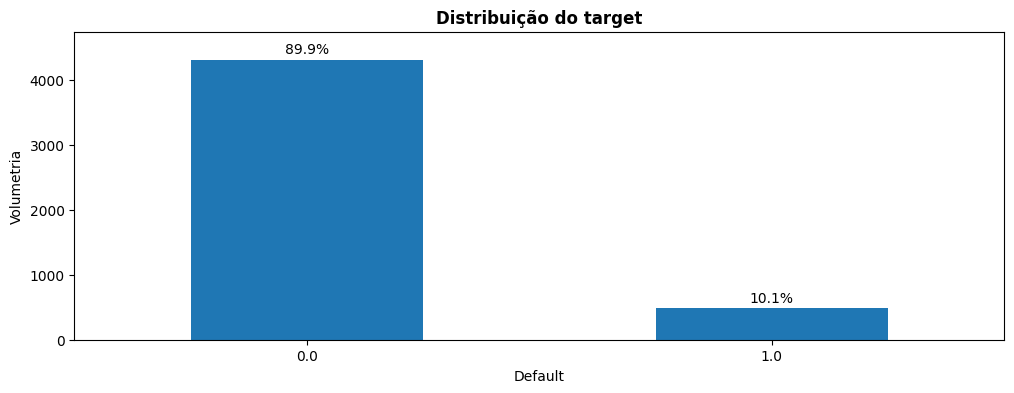

In [16]:
plot_categ(abt, 'atraso_90d', titulo='Distribuição do target', xlabel='Default',ylabel='Volumetria')

,Tx. default,Volumetria
mes_safra,,
2023-09,0.090909,198
2023-10,0.100000,200
2023-11,0.125000,200
2023-12,0.095000,200
2024-01,0.075000,200
2024-02,0.115578,199
2024-03,0.085000,200
2024-04,0.095477,199
2024-05,0.125000,200


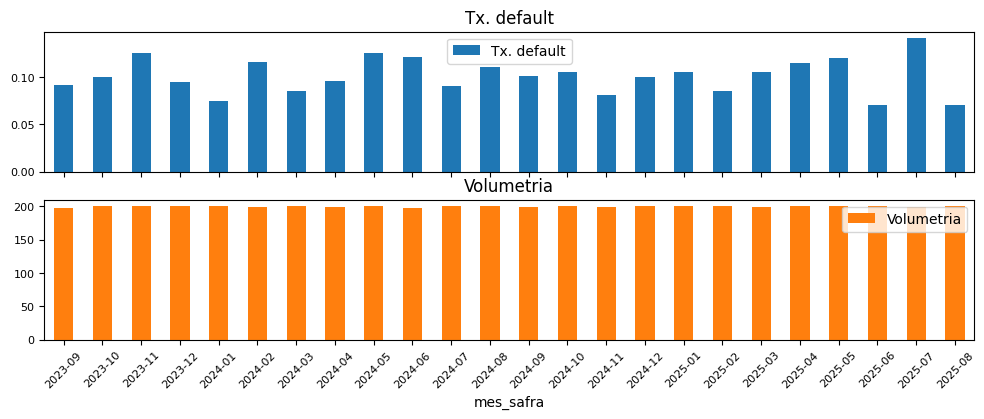

In [19]:
plot_txmau_categ(abt, column='mes_safra', column_mau='atraso_90d')

#### QUAL A INADIMPLÊNCIA POR CLIENTE?

In [20]:
mau = 1
df2 =abt[['id_cliente', 'atraso_90d']].copy()
df2['mau'] = [1 if x == mau else 0 for x in df2['atraso_90d']]
aux = df2.groupby('id_cliente')["mau"].agg(["mean", 'count']
                                          )
aux = aux.rename(columns={'mean' : 'tx_mau', 'count' : 'N'}).sort_values('tx_mau', ascending=False)
aux.head(20)

,tx_mau,N
id_cliente,,
C0030,0.291667,24
C0061,0.250000,24
C0163,0.250000,24
C0169,0.250000,24
C0031,0.208333,24
C0048,0.208333,24
C0006,0.208333,24
C0040,0.208333,24
C0185,0.208333,24


#### QUAL A INADIMPLÊNCIA OBSERVADA EM RELAÇÃO ÀS VARIÁVEIS?

- OBS: PARA VARIÁVEIS NUMÉRICAS - CATEGORIZAÇÃO POR QUANTIS

,Tx. default,Volumetria
estado_civil,,
casado,0.113150,981
divorciado,0.084650,886
nan,0.097222,792
solteiro,0.106646,1294
viuvo,0.099164,837


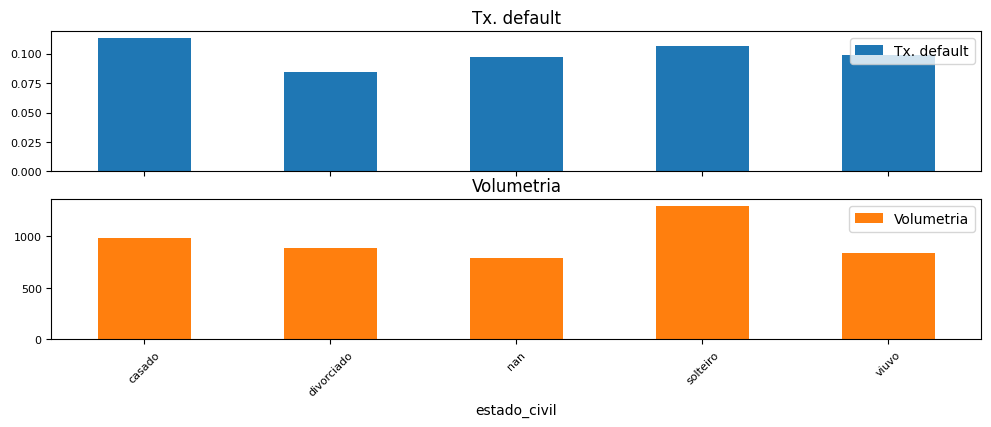

In [21]:
plot_txmau_categ(abt, column='estado_civil', column_mau='atraso_90d')

#### O SCORE INTERNO PRESENTE NA BASE DE CLIENTES ORDENA A INADIMPLÊNCIA?


c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:465: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


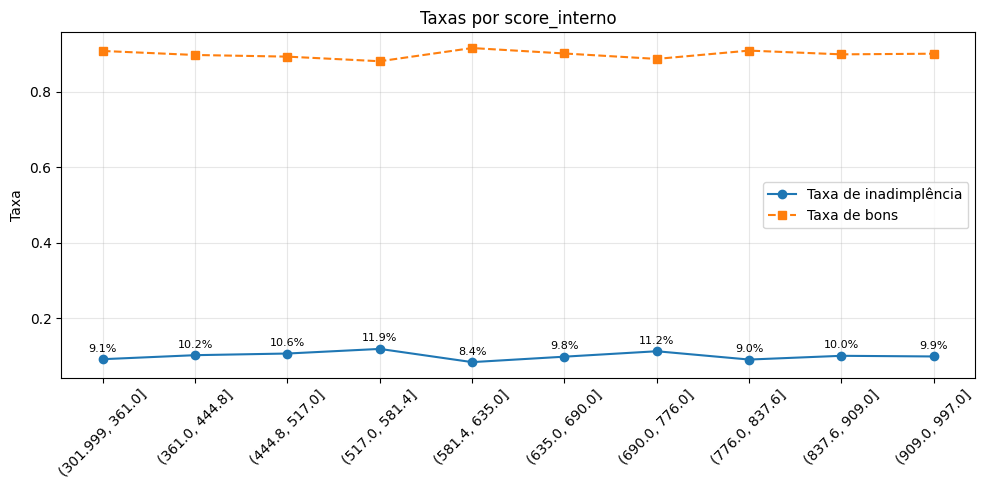

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(301.999, 361.0]",503,457,46,0.091451
1,"(361.0, 444.8]",431,387,44,0.102088
2,"(444.8, 517.0]",479,428,51,0.106472
3,"(517.0, 581.4]",455,401,54,0.118681
4,"(581.4, 635.0]",478,438,40,0.083682
5,"(635.0, 690.0]",479,432,47,0.098121
6,"(690.0, 776.0]",480,426,54,0.112500
7,"(776.0, 837.6]",431,392,39,0.090487
8,"(837.6, 909.0]",478,430,48,0.100418
9,"(909.0, 997.0]",456,411,45,0.098684


In [26]:
plot_inad_var(abt, "score_interno", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:465: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


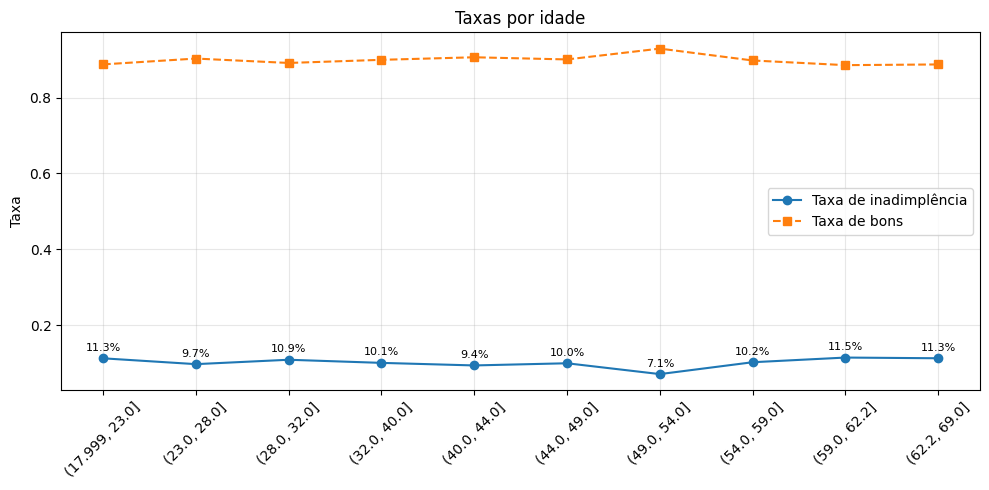

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(17.999, 23.0]",524,465,59,0.112595
1,"(23.0, 28.0]",504,455,49,0.097222
2,"(28.0, 32.0]",432,385,47,0.108796
3,"(32.0, 40.0]",527,474,53,0.100569
4,"(40.0, 44.0]",501,454,47,0.093812
5,"(44.0, 49.0]",432,389,43,0.099537
6,"(49.0, 54.0]",479,445,34,0.070981
7,"(54.0, 59.0]",528,474,54,0.102273
8,"(59.0, 62.2]",384,340,44,0.114583
9,"(62.2, 69.0]",479,425,54,0.112735


In [31]:
plot_inad_var(abt, "idade", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:465: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


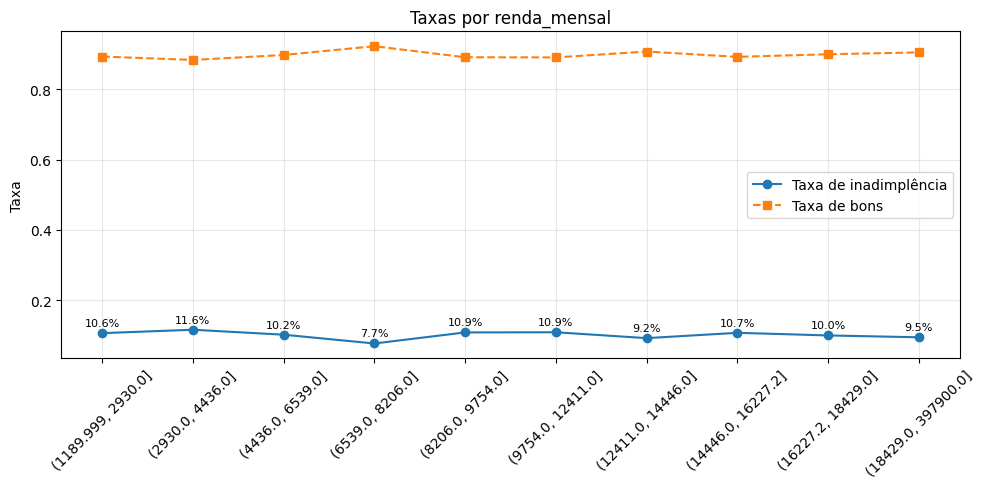

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(1189.999, 2930.0]",479,428,51,0.106472
1,"(2930.0, 4436.0]",456,403,53,0.116228
2,"(4436.0, 6539.0]",480,431,49,0.102083
3,"(6539.0, 8206.0]",454,419,35,0.077093
4,"(8206.0, 9754.0]",479,427,52,0.108559
5,"(9754.0, 12411.0]",477,425,52,0.109015
6,"(12411.0, 14446.0]",455,413,42,0.092308
7,"(14446.0, 16227.2]",456,407,49,0.107456
8,"(16227.2, 18429.0]",480,432,48,0.100000
9,"(18429.0, 397900.0]",454,411,43,0.094714


In [32]:
plot_inad_var(abt, "renda_mensal", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:465: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


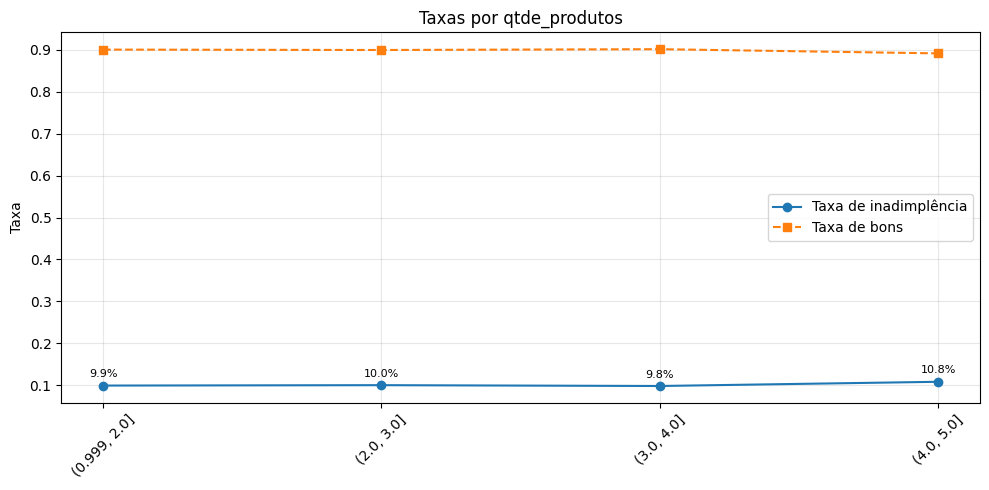

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(0.999, 2.0]",1987,1790,197,0.099144
1,"(2.0, 3.0]",1079,971,108,0.100093
2,"(3.0, 4.0]",744,671,73,0.098118
3,"(4.0, 5.0]",980,874,106,0.108163


In [33]:
plot_inad_var(abt, "qtde_produtos", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:465: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


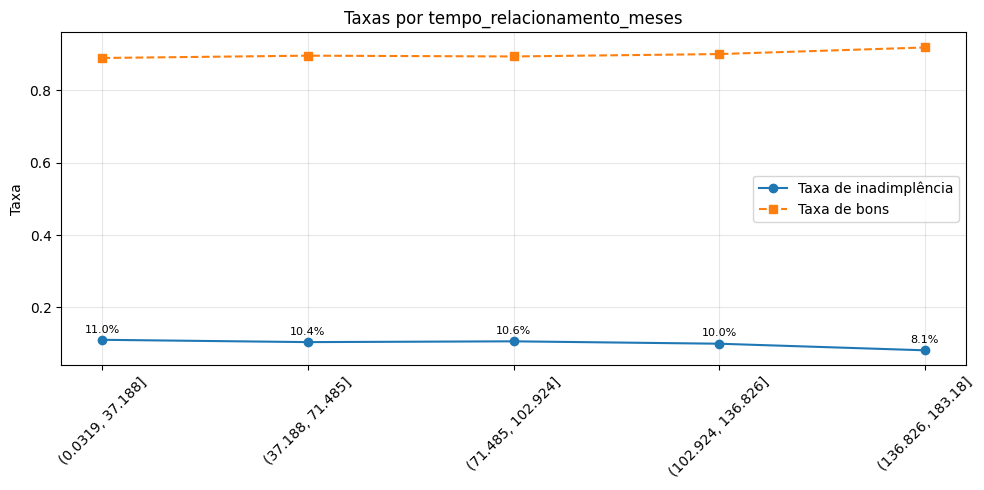

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(0.0319, 37.188]",924,822,102,0.110390
1,"(37.188, 71.485]",923,827,96,0.104009
2,"(71.485, 102.924]",923,825,98,0.106176
3,"(102.924, 136.826]",924,832,92,0.099567
4,"(136.826, 183.18]",922,847,75,0.081345


In [34]:
plot_inad_var(abt, "tempo_relacionamento_meses", target="atraso_90d", bins=5)

In [35]:
corr = abt.drop(columns=['id_cliente', 'data_referencia', 'data_abertura_conta', 'mes_abertura_conta','mes_safra', 'estado_civil']).corr(method = 'pearson')


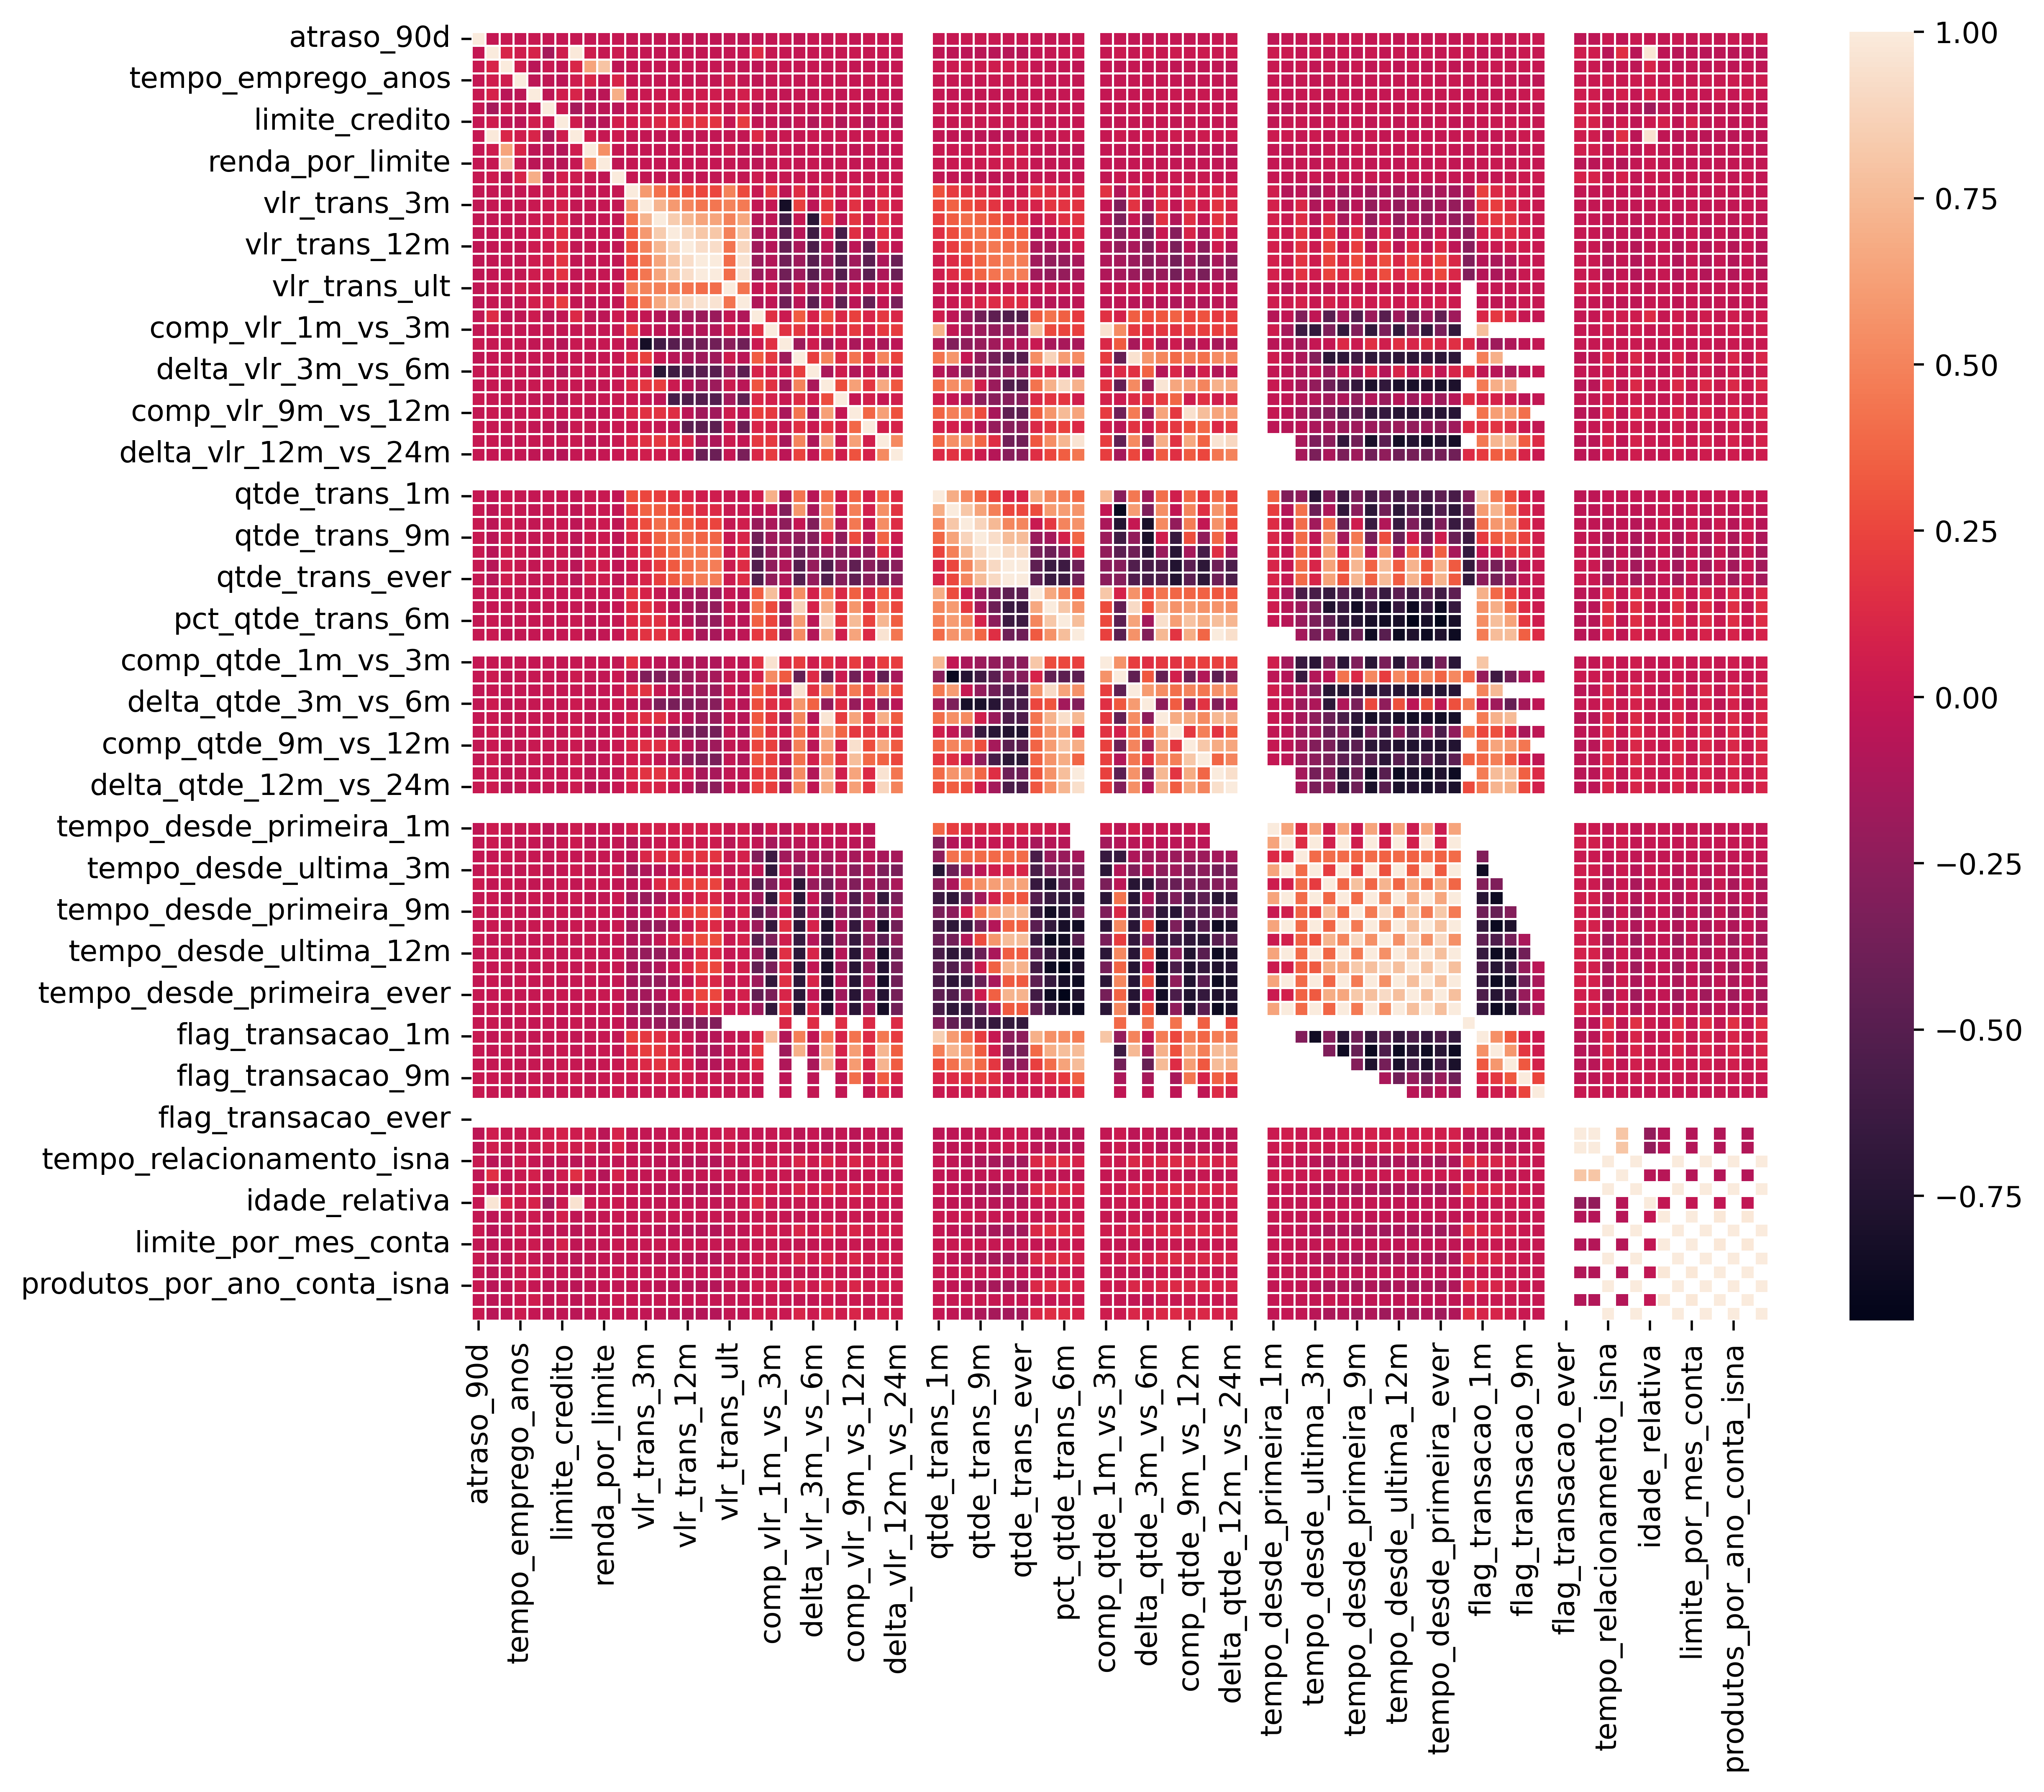

In [36]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=False,fmt=".2f", linewidth=.5)
plt.show()

In [50]:
cols_drop = ['id_cliente', 'data_referencia', 'data_abertura_conta', 'mes_abertura_conta','mes_safra']

resultado_conc = analisar_concentracao(
    abt=abt,
    max_vol=0.95,
    target="atraso_90d",
    cols_drop=cols_drop
)

print("Variáveis COM concentração:", resultado_conc["com_concentracao"])
print("Variáveis SEM concentração:", resultado_conc["sem_concentracao"])
print(resultado_conc["detalhes"].head())


Variáveis COM concentração: ['comp_vlr_24m_vs_ever', 'delta_vlr_24m_vs_ever', 'pct_qtde_trans_24m', 'comp_qtde_24m_vs_ever', 'delta_qtde_24m_vs_ever', 'flag_transacao_9m', 'flag_transacao_12m', 'flag_transacao_24m', 'flag_transacao_ever', 'tempo_relacionamento_isna', 'flag_cliente_antigo_isna', 'limite_por_ano_conta_isna', 'limite_por_mes_conta_isna', 'produtos_por_ano_conta_isna', 'produtos_por_mes_conta_isna']
Variáveis SEM concentração: ['idade', 'renda_mensal', 'estado_civil', 'tempo_emprego_anos', 'qtde_produtos', 'score_interno', 'limite_credito', 'idade2', 'log_renda', 'renda_por_limite', 'multi_produto_flag', 'vlr_trans_1m', 'vlr_trans_3m', 'vlr_trans_6m', 'vlr_trans_9m', 'vlr_trans_12m', 'vlr_trans_24m', 'vlr_trans_ever', 'vlr_trans_ult', 'vlr_trans_max', 'vlr_trans_min', 'comp_vlr_1m_vs_3m', 'delta_vlr_1m_vs_3m', 'comp_vlr_3m_vs_6m', 'delta_vlr_3m_vs_6m', 'comp_vlr_6m_vs_9m', 'delta_vlr_6m_vs_9m', 'comp_vlr_9m_vs_12m', 'delta_vlr_9m_vs_12m', 'comp_vlr_12m_vs_24m', 'delta_vlr_

In [49]:
resultado_conc["detalhes"]

,VARIAVEL,CONC_MAX
56,delta_qtde_24m_vs_ever,1.000000
55,comp_qtde_24m_vs_ever,1.000000
44,pct_qtde_trans_24m,1.000000
31,comp_vlr_24m_vs_ever,1.000000
32,delta_vlr_24m_vs_ever,1.000000
78,flag_transacao_ever,1.000000
77,flag_transacao_24m,1.000000
76,flag_transacao_12m,0.998903
75,flag_transacao_9m,0.982167
81,tempo_relacionamento_isna,0.963674


In [51]:
var_s_conc = resultado_conc["sem_concentracao"]

In [62]:
remover = remover_vars(
    abt[var_s_conc + ["atraso_90d"]], 
    target="atraso_90d", 
    iv_threshold=0.01, 
    corr_threshold=0.8
)


In [63]:
remover['final']

['tempo_desde_primeira_1m',
 'tempo_desde_primeira_3m',
 'vlr_trans_max',
 'tempo_desde_primeira_6m',
 'vlr_trans_min',
 'tempo_emprego_anos',
 'tempo_desde_ultima_12m',
 'vlr_trans_ult',
 'idade_relativa',
 'tempo_desde_primeira_9m',
 'comp_qtde_3m_vs_6m',
 'qtde_trans_12m',
 'renda_por_limite',
 'delta_qtde_6m_vs_9m',
 'delta_vlr_6m_vs_9m',
 'comp_vlr_6m_vs_9m',
 'comp_vlr_1m_vs_3m',
 'log_renda',
 'score_interno',
 'limite_credito']

In [64]:
len(remover['removidas_corr'])

20

In [65]:
len(remover['final'])

20

In [ ]:
col_retirar = cols_drop + ['atraso_90d']
X_TODAS = abt.drop(columns=col_retirar)

X_train_TODAS, X_test_TODAS = model_selection.train_test_split(X_TODAS,
                                                 test_size=0.2,
                                                 random_state=42
)

In [66]:
X = abt[remover['final']]
y = abt['atraso_90d']

In [67]:
(X.shape, len(y))

((4790, 20), 4790)

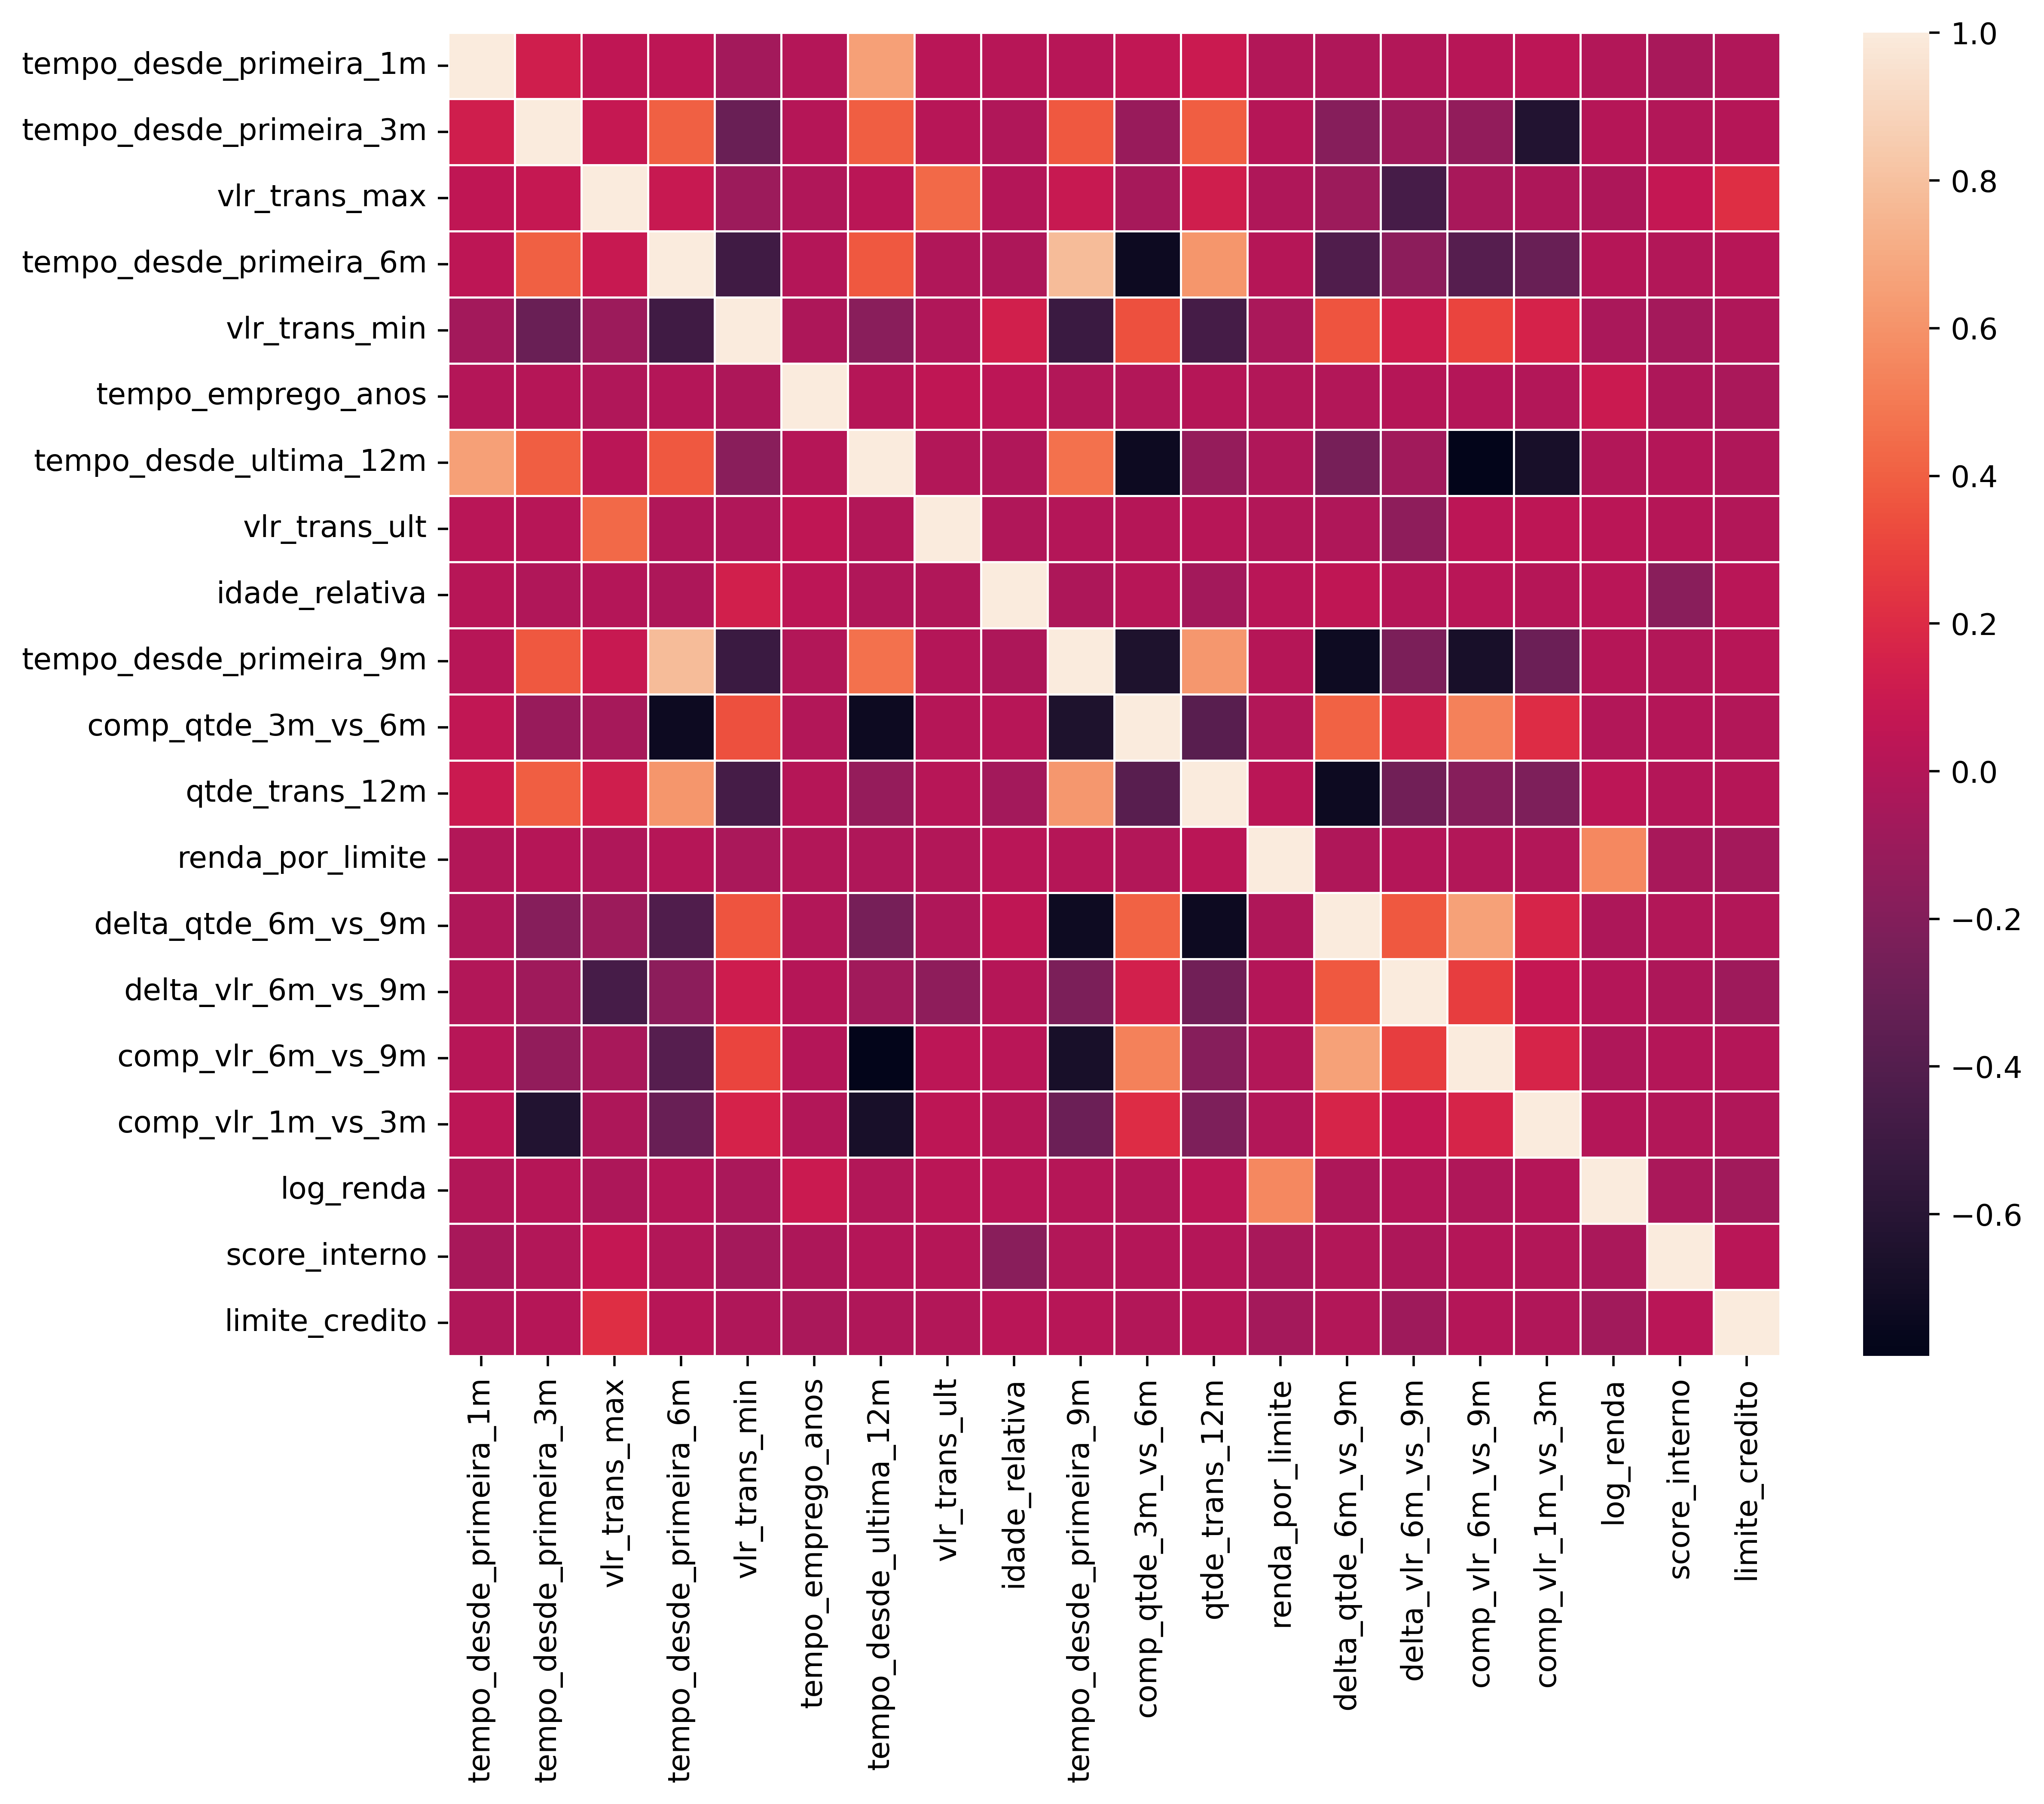

In [68]:
corr = X.corr(method = 'pearson')

plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=False,fmt=".2f", linewidth=.5)
plt.show()


In [69]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.2,
                                                                    random_state=42)

### 1. DECISION TREE CLASSIFIER

#### TREINO COM COLUNAS PRÉ-SELECIONADAS A PARTIR DA FUNÇÃO REMOVER_VARS()

In [70]:
arvore = tree.DecisionTreeClassifier(random_state=42,
                                     max_depth=5,
                                     min_samples_split=10,
                                     class_weight='balanced'
                                     )

arvore.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


[Text(0.5, 0.8333333333333334, 'vlr_trans_max <= 4987.195\ngini = 0.5\nsamples = 3832\nvalue = [1916.0, 1916.0]\nclass = 1.0'),
 Text(0.25, 0.5, 'tempo_emprego_anos <= 6.95\ngini = 0.5\nsamples = 3729\nvalue = [1859.778, 1906.174]\nclass = 1.0'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'idade_relativa <= 11.409\ngini = 0.253\nsamples = 103\nvalue = [56.222, 9.826]\nclass = 0.0'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

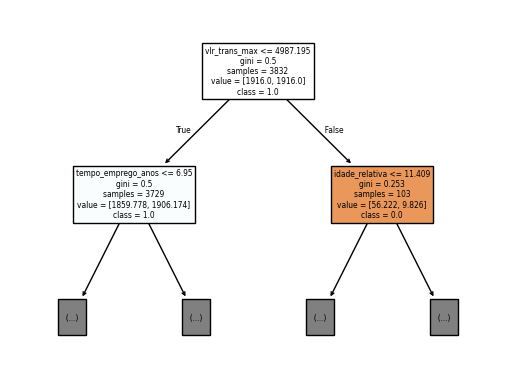

In [71]:
tree.plot_tree(arvore,
               feature_names=X_train.columns,
               max_depth=1,
               filled=True,
               class_names=[str(i) for i in arvore.classes_])

In [72]:
feature_importances= (pd.Series(arvore.feature_importances_,
                                index=X_train.columns)
                           .sort_values(ascending=False)
                           .reset_index()
                           )
feature_importances
feature_importances['acum.'] = feature_importances[0].cumsum()

# %%
best_features = feature_importances[feature_importances['acum.'] < 0.96]

In [73]:
best_features

,index,0,acum.
0,tempo_emprego_anos,0.268635,0.268635
1,delta_qtde_6m_vs_9m,0.129899,0.398534
2,vlr_trans_max,0.121632,0.520166
3,limite_credito,0.091930,0.612097
4,vlr_trans_min,0.063337,0.675434
5,tempo_desde_primeira_3m,0.059865,0.735300
6,tempo_desde_primeira_6m,0.057682,0.792982
7,tempo_desde_primeira_9m,0.057305,0.850287
8,idade_relativa,0.056422,0.906709
9,tempo_desde_primeira_1m,0.052967,0.959676


In [74]:
y_train_predict = arvore.predict(X_train[best_features])
y_train_proba = arvore.predict_proba(X_train[best_features])[:, 1]

acc_train = metrics.accuracy_score(y_train, y_train_predict)
auc_train = metrics.roc_auc_score(y_train, y_train_proba)
roc_train = metrics.roc_curve(y_train, y_train_proba)

print("Acurácia treino: ", acc_train)
print("AUC treino: ", auc_train)


y_test_predict = arvore.predict(X_test[best_features])
y_test_proba = arvore.predict_proba(X_test[best_features])[:, 1]

acc_test = metrics.accuracy_score(y_test, y_test_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_proba)
roc_test = metrics.roc_curve(y_test,y_test_proba)
                             
                             
print("Acurácia teste: ", acc_test)
print("AUC teste: ", auc_test)

Acurácia treino:  0.8982254697286013
AUC treino:  0.5
Acurácia teste:  0.9018789144050104
AUC teste:  0.5


c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:425: RuntimeWarning: invalid value encountered in scalar divide
  precision_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(preds == 1)


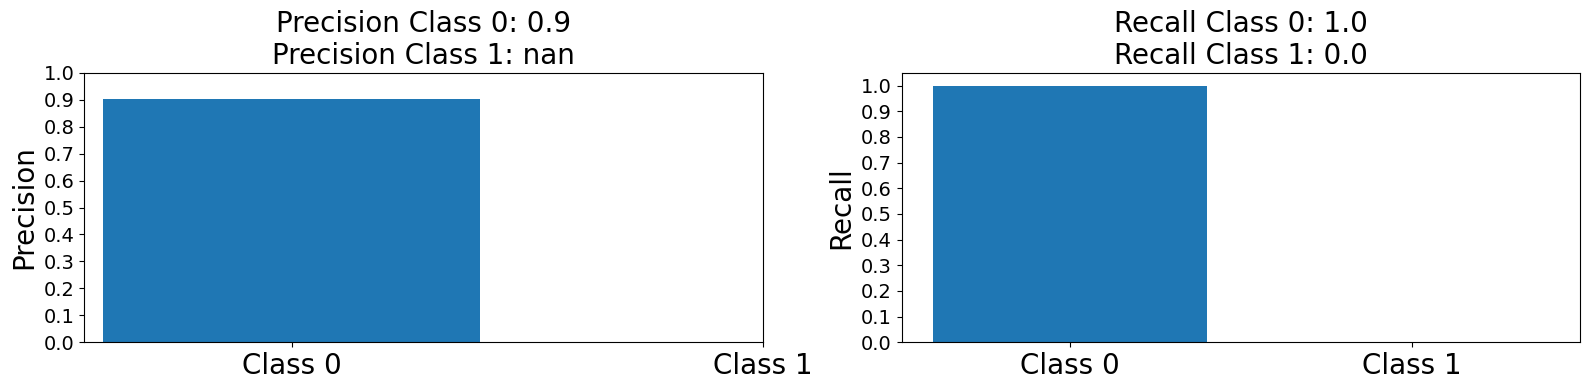

In [78]:
get_precisions_recalls(y_test,y_test_predict)

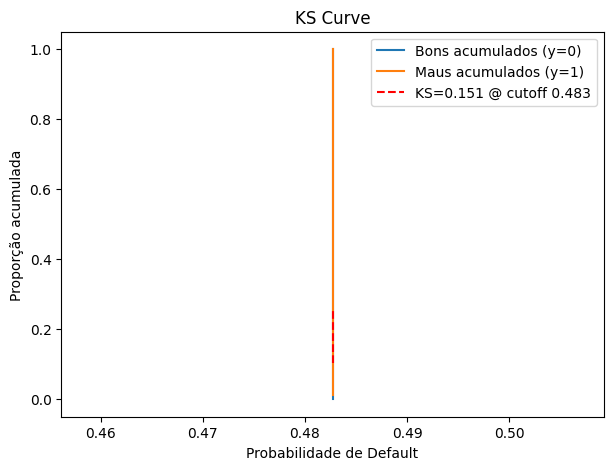

ValueError: If using all scalar values, you must pass an index

In [77]:
plotar_ks(y_test,y_test_proba)

### 2. CATBOOST


In [79]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np

#### 2.1 TREINO COM TODAS AS COLUNAS QUE NÃO SEJAM ID OU DATAS

In [80]:
cat_features = [col for col in X_train_TODAS.columns if X_train_TODAS[col].dtype.name in ["object", "category"]]

cat_features

NameError: name 'X_train_TODAS' is not defined

In [ ]:
# ===============================
# 1. Identificar variáveis categóricas
# ===============================
cat_features = [col for col in X_train_TODAS.columns if X_train_TODAS[col].dtype.name in ["object", "category"]]

print("Variáveis categóricas:", cat_features)

# ===============================
# 2. Definir modelo base
# ===============================
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

catboost = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    class_weights=[1, weight_minority_class],   # penaliza mais a classe 1 (inadimplente), ajuste se precisar
    logging_level='Info'
)

# ===============================
# 3. Espaço de hiperparâmetros
# ===============================
param_dist = {
    "depth": [4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 5),
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "iterations": [200, 400, 600, 800],
    "border_count": [32, 64, 128]
}

# ===============================
# 4. RandomizedSearchCV
# ===============================
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=20,           
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# CatBoost precisa de Pool para saber quais colunas são categóricas
train_pool = Pool(X_train_TODAS, y_train, cat_features=cat_features)

# Ajustar busca
random_search.fit(X_train_TODAS, y_train, cat_features=cat_features)




In [ ]:
# ===============================
# 5. Avaliar no teste
# ===============================
best_model = random_search.best_estimator_
y_proba_cat = best_model.predict_proba(X_test_TODAS)[:, 1]
y_pred_cat = best_model.predict(X_test_TODAS)

print("Melhores parâmetros:", random_search.best_params_)
print("AUC:", roc_auc_score(y_test, y_proba_cat))
print("F1 :", f1_score(y_test, y_pred_cat))
print("Precisão:", precision_score(y_test, y_pred_cat))
print("Recall:", recall_score(y_test, y_pred_cat))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_cat))

In [ ]:
plotar_ks(y_test,y_proba_cat, titulo='KS CATBOOST')

In [ ]:
import pandas as pd
feat_imp = pd.DataFrame({
    "feature": X_train_TODAS.columns,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)
print(feat_imp.head(20))


#### 2.2 TREINO COM COLUNAS PRÉ-SELECIONADAS A PARTIR DA FUNÇÃO REMOVER_VARS()

In [ ]:
# ===============================
# 1. Identificar variáveis categóricas
# ===============================
cat_features = [col for col in X_train.columns if X_train[col].dtype.name in ["object", "category"]]

print("Variáveis categóricas:", cat_features)

# ===============================
# 2. Definir modelo base
# ===============================
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

catboost = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    class_weights=[1, weight_minority_class],   # penaliza mais a classe 1 (inadimplente), ajuste se precisar
    logging_level="Silent"
)

# ===============================
# 3. Espaço de hiperparâmetros
# ===============================
param_dist = {
    "depth": [4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "iterations": [200, 400, 600, 800],
    "border_count": [32, 64, 128]
}

# ===============================
# 4. RandomizedSearchCV
# ===============================
random_search2 = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=20,              # nº de combinações testadas (ajuste se quiser mais)
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# CatBoost precisa de Pool para saber quais colunas são categóricas
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# Ajustar busca
random_search2.fit(X_train, y_train, cat_features=cat_features)




In [ ]:
# ===============================
# 5. Avaliar no teste
# ===============================
best_model2 = random_search2.best_estimator_
y_proba_cat2 = best_model2.predict_proba(X_test)[:, 1]
y_pred_cat2 = best_model2.predict(X_test)

print("Melhores parâmetros:", random_search.best_params_)
print("AUC:", roc_auc_score(y_test, y_proba_cat2))
print("F1 :", f1_score(y_test, y_pred_cat2))
print("Precisão:", precision_score(y_test, y_pred_cat2))
print("Recall:", recall_score(y_test, y_pred_cat2))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_cat2))

In [ ]:
plotar_ks(y_test,y_proba_cat2, titulo='KS CATBOOST 2')

## COMO ARRUMAR?

#### Proposta 1 - UPWEIGHT THE MINORITY CLASS

In [ ]:
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

weight_minority_class

In [ ]:
arvore2 = tree.DecisionTreeClassifier(class_weight={0:1, 1:weight_minority_class}, random_state=42)
arvore2.fit(X_train, y_train)
preds = arvore2.predict(X_test)

In [ ]:
get_precisions_recalls(y_test, preds)

In [ ]:
y_train_predict2 = arvore2.predict(X_train)
y_train_proba2 = arvore2.predict_proba(X_train)[:, 1]

acc_train2 = metrics.accuracy_score(y_train, y_train_predict2)
auc_train2 = metrics.roc_auc_score(y_train, y_train_proba2)
roc_train2 = metrics.roc_curve(y_train, y_train_proba2)

print("Acurácia treino: ", acc_train2)
print("AUC treino: ", auc_train2)

y_test_predict2 = arvore2.predict(X_test)
y_test_proba2 = arvore2.predict_proba(X_test)[:, 1]

acc_test2 = metrics.accuracy_score(y_test, y_test_predict2)
auc_test2 = metrics.roc_auc_score(y_test, y_test_proba2)
roc_test2 = metrics.roc_curve(y_test,y_test_proba2)
                             
                             
print("Acurácia teste: ", acc_test2)
print("AUC teste: ", auc_test2)

#### Proposta 2 - Oversample Minority Class

In [ ]:
#get indices of each class
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices = np.concatenate([indices_0, indices_1])

#get weights for each class
weights = np.empty(indices_0.shape[0] + indices_1.shape[0])
weights[:indices_0.shape[0]] = 1
weights[indices_0.shape[0]:] = weight_minority_class
weights = weights/np.sum(weights)

#sample new indices
sampled_indices = np.random.choice(indices, indices.shape[0], p=weights)

In [ ]:
# construir datasets oversampled
X_train_oversampled = X_train.iloc[sampled_indices]
labels_train_oversampled = y_train.iloc[sampled_indices]


In [ ]:
print('Fraction of positive labels in oversampled data:', str(round(100*np.mean(labels_train_oversampled),3)) + '%')

In [ ]:
arvore3 = tree.DecisionTreeClassifier(random_state=42,
                                  max_depth=5,
                                  min_samples_split=10)

arvore3.fit(X_train_oversampled, labels_train_oversampled)
preds = arvore3.predict(X_test)

In [ ]:
get_precisions_recalls(y_test, preds)

In [ ]:
y_train_predict3 = arvore3.predict(X_train_oversampled)
y_train_proba3 = arvore3.predict_proba(X_train_oversampled)[:, 1]

acc_train3 = metrics.accuracy_score(labels_train_oversampled, y_train_predict3)
auc_train3 = metrics.roc_auc_score(labels_train_oversampled, y_train_proba3)
roc_train3 = metrics.roc_curve(labels_train_oversampled, y_train_proba3)

print("Acurácia treino: ", acc_train3)
print("AUC treino: ", auc_train3)

y_test_predict3 = arvore3.predict(X_test)
y_test_proba3 = arvore3.predict_proba(X_test)[:, 1]

acc_test3 = metrics.accuracy_score(y_test, y_test_predict3)
auc_test3 = metrics.roc_auc_score(y_test, y_test_proba3)
roc_test3 = metrics.roc_curve(y_test,y_test_proba3)
                           
print("Acurácia teste: ", acc_test3)
print("AUC teste: ", auc_test3)

